In [1]:
!pip install tensorflow scikit-learn


## **1. Install and Import Libraries**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

## **2. Load and Prepare Data**


In [16]:
# Load data
df = pd.read_csv('/content/drive/MyDrive/Data/web_traffic_sample.csv', parse_dates=['date'])
df.set_index('date', inplace=True)

In [21]:
df.head()


,pageviews
date,
2022-01-01 00:00:00,415
2022-01-01 01:00:00,407
2022-01-01 02:00:00,434
2022-01-01 03:00:00,462
2022-01-01 04:00:00,423


In [22]:
df.describe()

,pageviews
count,10000.000000
mean,501.793900
std,85.376612
min,262.000000
25%,436.000000
50%,502.000000
75%,568.000000
max,752.000000


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10000 entries, 2022-01-01 00:00:00 to 2023-02-21 15:00:00
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   pageviews  10000 non-null  int64
dtypes: int64(1)
memory usage: 156.2 KB


In [15]:
# Select only 'pageviews' for LSTM
data = df[['pageviews']]

## **3.Visualize**

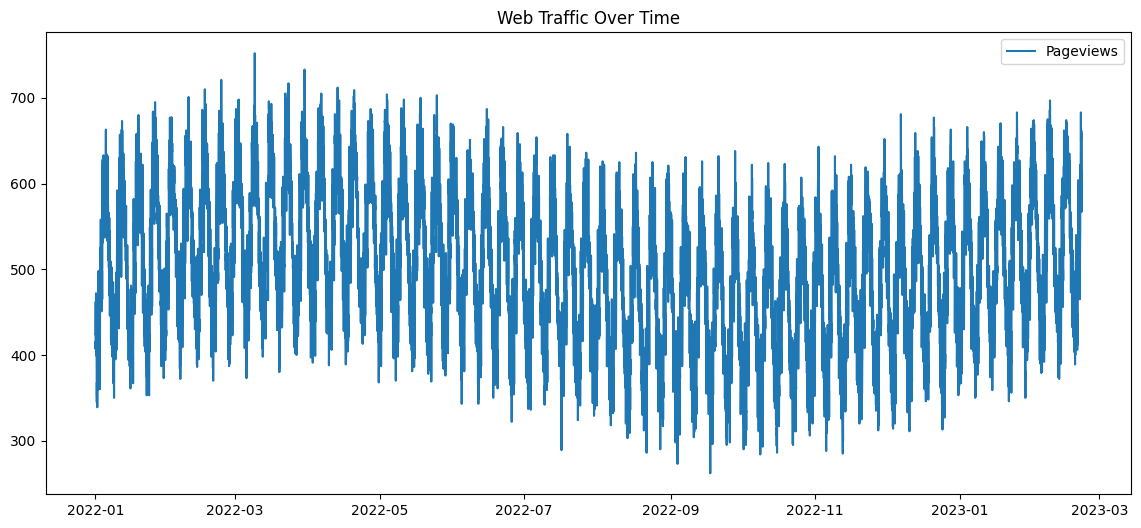

In [4]:
# Visualize
plt.figure(figsize=(14,6))
plt.plot(data, label='Pageviews')
plt.title('Web Traffic Over Time')
plt.legend()
plt.show()

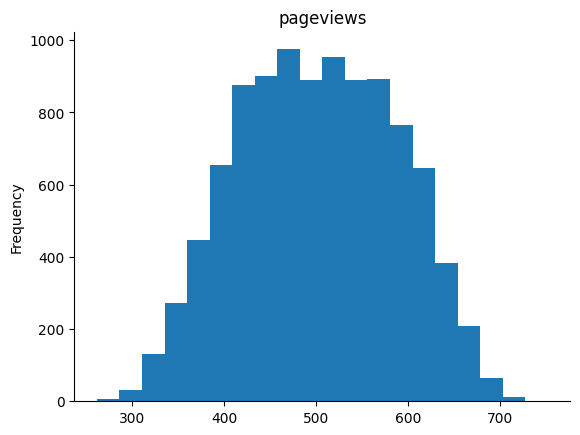

In [28]:
from matplotlib import pyplot as plt
df['pageviews'].plot(kind='hist', bins=20, title='pageviews')
plt.gca().spines[['top', 'right',]].set_visible(False)

## **4. Scale the Data**

In [5]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)

print(f"Scaled Data Shape: {scaled_data.shape}")


Scaled Data Shape: (10000, 1)


## **5. Create Sequences for LSTM**

In [6]:
# Function to create sequences
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Set sequence length
SEQ_LEN = 24  # last 24 hours to predict the next

X, y = create_sequences(scaled_data, SEQ_LEN)

# Reshape X for LSTM [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")


X shape: (9976, 24, 1)
y shape: (9976,)


## **6. Train/Test Split**

In [30]:
train_size = int(len(X) * 0.8)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")


Training samples: 7980
Testing samples: 1996


## **7. Build LSTM Model**

In [8]:
# Build model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(SEQ_LEN, 1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

## **8. Train Model**

In [9]:
# Fit model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0316 - val_loss: 0.0067
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0063 - val_loss: 0.0047
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0053 - val_loss: 0.0046
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0050 - val_loss: 0.0045
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.0050 - val_loss: 0.0050
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0050 - val_loss: 0.0046
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 0.0050 - val_loss: 0.0045
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0048 - val_loss: 0.0044
Epoch 9/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0048 - val_loss: 0.0044
Epoch 10/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.0049 - val_loss: 0.0045


## **9. Plot Loss Curve**

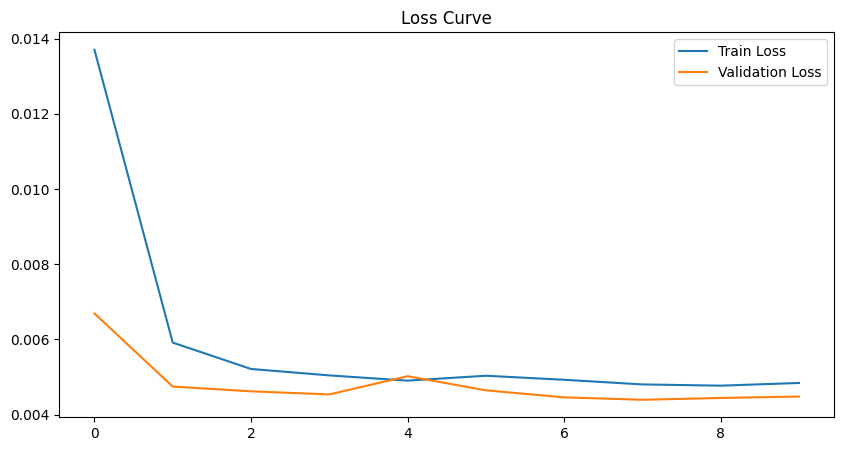

In [10]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()


## **10**. **Predictions**

In [11]:
# Predict
y_pred = model.predict(X_test)

# Inverse scale
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_rescaled = scaler.inverse_transform(y_pred)

# Evaluate
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))

print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
MAE: 26.11
RMSE: 32.80


## **11. Plot Actual vs Predicted**

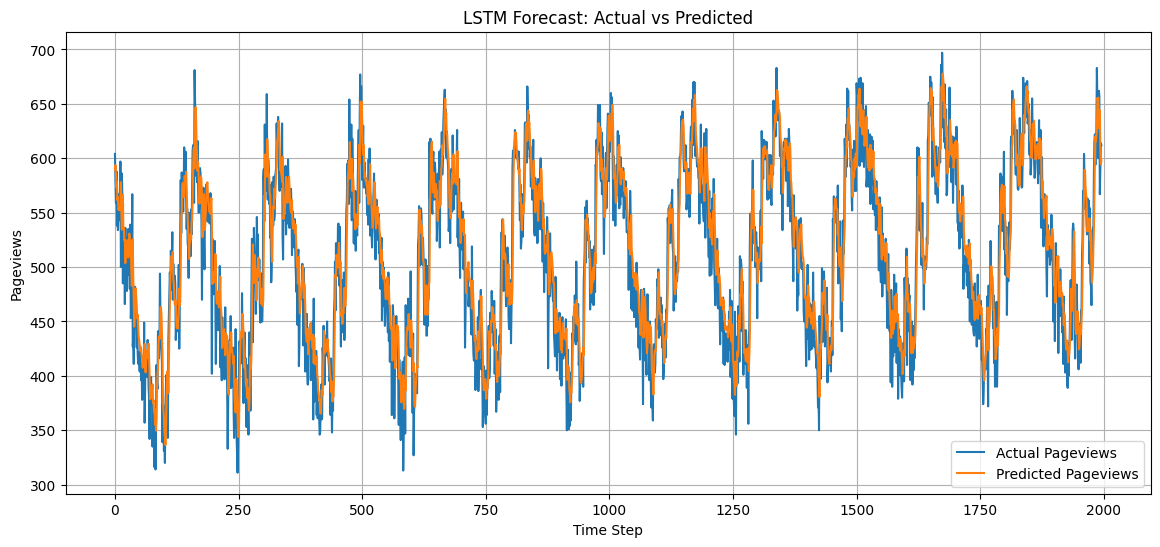

In [12]:
plt.figure(figsize=(14,6))
plt.plot(y_test_rescaled, label='Actual Pageviews')
plt.plot(y_pred_rescaled, label='Predicted Pageviews')
plt.title('LSTM Forecast: Actual vs Predicted')
plt.xlabel('Time Step')
plt.ylabel('Pageviews')
plt.legend()
plt.grid()
plt.show()
